<a href="https://colab.research.google.com/github/jhl0580/prac_class/blob/main/personal_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install bayesian-optimization

In [2]:
pip install pysal

In [3]:
import numpy as np
import pandas as pd

from scipy.stats import norm, skew
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

import time
import itertools

import statsmodels.api as sm
import pysal
import libpysal
from spreg import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics

from bayes_opt import BayesianOptimization
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import *


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.4) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [4]:
train_data = pd.read_csv('/content/FIFA_train.csv')
test_data = pd.read_csv('/content/FIFA_test.csv')

# __전처리__

__분석과제에서 종속변수는 축구선수들의 이적료이고, 이를 예측하기 위한 다양한 독립변수가 존재한다.  
먼저 다양한 예측모형에서 사용할 수 있도록 범주형 독립변수들을 더미변수로 변환한다.__

In [5]:
y = train_data.iloc[:,11:12]
X = train_data.iloc[:, 2:10]

In [6]:
#continent변수 dummy변수로 변환

def continent_dummy(df):
  if df.continent == 'europe':
    df.eu = 1
  elif df.continent == 'south america':
    df.sa = 1
  elif df.continent == 'asia':
    df.asia = 1
  elif df.continent == 'africa':
    df.africa = 1
  else:
    df.oc = 1
  return df


X['eu'] = 0
X['sa'] = 0
X['asia'] = 0
X['africa'] = 0
X['oc'] = 0

X = X.apply(continent_dummy, axis=1)

del X['continent']

In [7]:
#과제 및 데이터가 주어진 2019년을 기준으로 잔여 계약기간을 계산

X['contract_remain'] = 0

def contract_dummy(df):
  if len(df['contract_until']) != 4:
    df['contract_until'] = df['contract_until'][-4:]
  return df

X = X.apply(contract_dummy, axis=1)

X['contract_until'] = X['contract_until'].astype(int)

X['contract_remain'] = X['contract_until'] - 2019

del X['contract_until']

In [8]:
#position변수를 dummy변수로 변환

X['MF'] = 0
X['DF'] = 0
X['ST'] = 0
X['GK'] = 0

def position_dummy(df):
  if df['position'] == 'MF':
    df['MF'] = 1
  elif df['position'] == 'DF':
    df['DF'] = 1
  elif df['position'] == 'ST':
    df['ST'] = 1
  else:
    df['GK'] = 1
  return df

X = X.apply(position_dummy, axis=1)

del X['position']

In [9]:
#prefer_foot변수를 1-0 encoding

def prefer_foot(df):
  if df['prefer_foot'] == 'right':
    df['prefer_foot'] = 1
  else:
    df['prefer_foot'] = 0
  return df

X = X.apply(prefer_foot, axis=1)

__여기까지 train data의 독립변수에 대한 기본적인 전처리를 진행했다. 이어서 test data의 독립변수에도 같은 전처리를 진행한다.__

In [10]:
final_test_x = test_data.iloc[:, 2:10]

In [11]:
def continent_dummy(df):
  if df.continent == 'europe':
    df.eu = 1
  elif df.continent == 'south america':
    df.sa = 1
  elif df.continent == 'asia':
    df.asia = 1
  elif df.continent == 'africa':
    df.africa = 1
  else:
    df.oc = 1
  return df


final_test_x['eu'] = 0
final_test_x['sa'] = 0
final_test_x['asia'] = 0
final_test_x['africa'] = 0
final_test_x['oc'] = 0

final_test_x = final_test_x.apply(continent_dummy, axis=1)

del final_test_x['continent']

In [12]:
final_test_x['contract_remain'] = 0

def contract_dummy(df):
  if len(df['contract_until']) != 4:
    df['contract_until'] = df['contract_until'][-4:]
  return df

final_test_x = final_test_x.apply(contract_dummy, axis=1)

final_test_x['contract_until'] = final_test_x['contract_until'].astype(int)

final_test_x['contract_remain'] = final_test_x['contract_until'] - 2019

del final_test_x['contract_until']

In [13]:
final_test_x['MF'] = 0
final_test_x['DF'] = 0
final_test_x['ST'] = 0
final_test_x['GK'] = 0

def position_dummy(df):
  if df['position'] == 'MF':
    df['MF'] = 1
  elif df['position'] == 'DF':
    df['DF'] = 1
  elif df['position'] == 'ST':
    df['ST'] = 1
  else:
    df['GK'] = 1
  return df

final_test_x = final_test_x.apply(position_dummy, axis=1)

del final_test_x['position']

In [14]:
def prefer_foot(df):
  if df['prefer_foot'] == 'right':
    df['prefer_foot'] = 1
  else:
    df['prefer_foot'] = 0
  return df

final_test_x = final_test_x.apply(prefer_foot, axis=1)

__이어서 몇몇 독립변수들과 종속변수의 편향 정도를 확인한 뒤 필요한 경우 추가적인 전처리를 진행한다.__

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


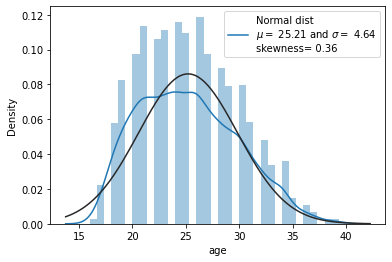

In [15]:
sns.distplot(X['age'], fit = norm)
(mu, sigma) = norm.fit(X['age'])
skewness = skew(X['age'])
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}\nskewness= {:.2f}'.format(mu, sigma, skewness)], loc = 'best')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


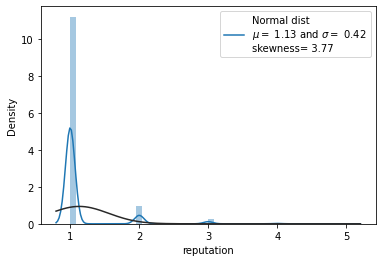

In [16]:
sns.distplot(X['reputation'], fit = norm)
(mu, sigma) = norm.fit(X['reputation'])
skewness = skew(X['reputation'])
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}\nskewness= {:.2f}'.format(mu, sigma, skewness)], loc = 'best')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


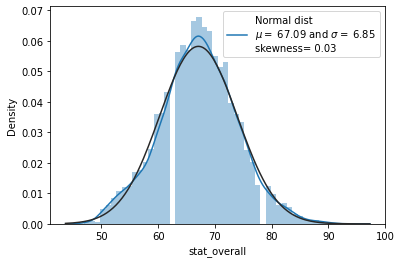

In [17]:
sns.distplot(X['stat_overall'], fit = norm)
(mu, sigma) = norm.fit(X['stat_overall'])
skewness = skew(X['stat_overall'])
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}\nskewness= {:.2f}'.format(mu, sigma, skewness)], loc = 'best')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


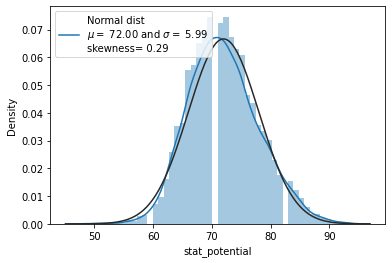

In [18]:
sns.distplot(X['stat_potential'], fit = norm)
(mu, sigma) = norm.fit(X['stat_potential'])
skewness = skew(X['stat_potential'])
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}\nskewness= {:.2f}'.format(mu, sigma, skewness)], loc = 'best')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


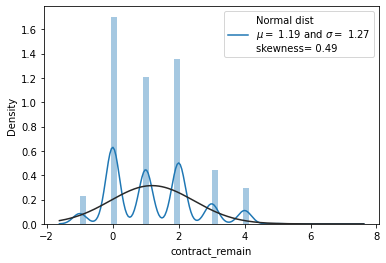

In [19]:
sns.distplot(X['contract_remain'], fit = norm)
(mu, sigma) = norm.fit(X['contract_remain'])
skewness = skew(X['contract_remain'])
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}\nskewness= {:.2f}'.format(mu, sigma, skewness)], loc = 'best')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


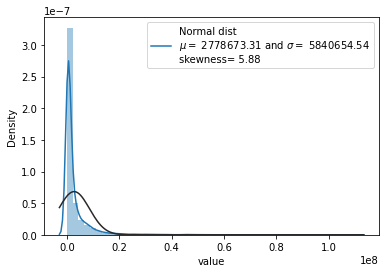

In [20]:
sns.distplot(y['value'], fit = norm)
(mu, sigma) = norm.fit(y['value'])
skewness = skew(y['value'])
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}\nskewness= {:.2f}'.format(mu, sigma, skewness)], loc = 'best')
plt.show()

__종속변수인 value변수와 독립변수 reputation변수에서 심한 편향을 발견했다. 이를 해결하기 위해 두 변수를 로그변환한다.  
또한, X변수들을 표준화한다.__

In [21]:
y = np.log1p(y)

In [22]:
X['reputation'] = np.log1p(X['reputation'])

scaler = StandardScaler()

X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


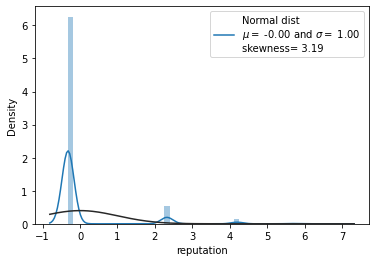

In [23]:
sns.distplot(X['reputation'], fit = norm)
(mu, sigma) = norm.fit(X['reputation'])
skewness = skew(X['reputation'])
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}\nskewness= {:.2f}'.format(mu, sigma, skewness)], loc = 'best')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


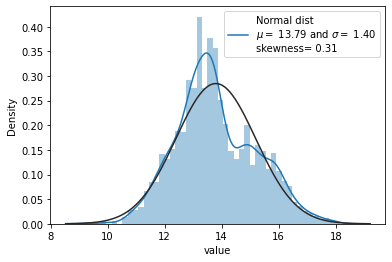

In [24]:
sns.distplot(y['value'], fit = norm)
(mu, sigma) = norm.fit(y['value'])
skewness = skew(y['value'])
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}\nskewness= {:.2f}'.format(mu, sigma, skewness)], loc = 'best')
plt.show()

__로그 변환 결과, reputation변수는 조금은 나아졌지만 여전히 편향이 심해 보인다. 반면, 종속변수는 편향이 더이상 보이지 않는다.__

In [25]:
final_test_x['reputation'] = np.log1p(final_test_x['reputation'])

scaler = StandardScaler()

final_test_x = pd.DataFrame(scaler.fit_transform(final_test_x), columns = final_test_x.columns)

In [26]:
y_reg = y.copy()
X_reg = X.copy()

In [27]:
X_reg = sm.add_constant(X_reg, has_constant='add') #회귀분석을 위해 독립변수에 상수항 추가

# __train, test 나누기__

In [28]:
#회귀분석에서 사용할 데이터
train_X_reg, test_X_reg = train_test_split(X_reg, test_size=0.2, random_state=1)
train_y_reg, test_y_reg = train_test_split(y_reg, test_size=0.2, random_state=1)

In [29]:
#머신러닝에서 사용할 데이터
train_x, test_x = train_test_split(X, test_size=0.2, random_state=1)
train_y, test_y = train_test_split(y, test_size=0.2, random_state=1)

# __회귀분석__

## __변수선택법 정의__

In [30]:
def processSubset(X,y,feature_set):
    model = sm.OLS(y,X[list(feature_set)]) # Modeling
    regr = model.fit() # model fitting
    AIC = regr.aic # model's AIC
    return {"model" : regr, "AIC" : AIC}

In [31]:
#전진선택법

def forward(X,y,predictors):

    # predictor - 현재 선택되어있는 변수
    # 데이터 변수들이 미리정의된 predictors에 있는지 없는지 확인 및 분류
    
    remaining_predictors = [p for p in X.columns.difference(['const']) if p not in predictors]
    tic = time.time()
    results = []
    for p in remaining_predictors :
        results.append(processSubset(X=X,y=y,feature_set=predictors+[p]+['const']))
    
    models = pd.DataFrame(results)
    
    best_model = models.loc[models['AIC'].argmin()] #AIC가 가장 낮은 모델을 선택
    toc = time.time()
    print("Processed ",models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic))
    print("Selected predictors:",best_model["model"].model.exog_names,"AIC: ",best_model[0])
    return best_model
    
#전진선택법 모델

def forward_model(X,y):

    Fmodels = pd.DataFrame(columns=["AIC","model"])
    tic = time.time()
     
    predictors = []
    
    for i in range(1,len(X.columns.difference(['const']))+1):
        Forward_result = forward(X=X,y=y,predictors=predictors)
        if i > 1:
            if Forward_result["AIC"] > Fmodel_before:
                break
        Fmodels.loc[i] = Forward_result
        predictors = Fmodels.loc[i]["model"].model.exog_names
        Fmodel_before = Fmodels.loc[i]["AIC"]
        predictors = [k for k in predictors if k != 'const']
    toc = time.time()
    print("Total elapsed time:",(toc-tic), "seconds.")
    
    return (Fmodels['model'][len(Fmodels['model'])])

In [32]:
#후진제거법

def backward(X,y,predictors):
    tic= time.time()
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors) - 1):
        results.append(processSubset(X=X,y=y,feature_set=list(combo)+['const']))
    models = pd.DataFrame(results)
    
    best_model = models.loc[models['AIC'].argmin()]    # 가장 낮은 AIC를 가진 모델을 선택
    toc = time.time()
    
    print("Processed ",models.shape[0], "models on", len(predictors) - 1, "predictors in",(toc-tic))
    print("Selected predictors:",best_model['model'].model.exog_names,' AIC:',best_model[0])
    return best_model
    
#후진제거법 모델

def backward_model(X,y) :
    Bmodels = pd.DataFrame(columns=["AIC","model"], index = range(1,len(X.columns)))
    tic = time.time()
    predictors = X.columns.difference(['const'])
    Bmodel_before = processSubset(X,y,predictors)['AIC']
    while (len(predictors) > 1):
        Backward_result = backward(X=X, y= y, predictors=predictors)
        if Backward_result['AIC'] > Bmodel_before :
            break
        Bmodels.loc[len(predictors) -1] = Backward_result
        predictors = Bmodels.loc[len(predictors) - 1]['model'].model.exog_names
        Bmodel_before = Backward_result["AIC"]
        predictors = [k for k in predictors if k != 'const']

    toc = time.time()
    print("Total elapsed time:",(toc-tic),"seconds.")
    return Bmodels["model"].dropna().iloc[0]

In [33]:
#변수선택법

def Stepwise_model(X,y):
    Stepmodels = pd.DataFrame(columns = ["AIC","model"])
    tic = time.time()
    predictors = []
    Smodel_before = processSubset(X,y,predictors + ['const'])['AIC']
    
    
    for i in range(1,len(X.columns.difference(['const']))+1) :
        Forward_result = forward(X=X,y=y,predictors = predictors) # constant added
        print('forward')
        Stepmodels.loc[i] = Forward_result
        predictors = Stepmodels.loc[i]["model"].model.exog_names
        predictors = [k for k in predictors if k != 'const']
        Backward_result = backward(X=X,y=y,predictors = predictors)
        if Backward_result["AIC"] < Forward_result["AIC"]:
            Stepmodels.loc[i] = Backward_result
            predictors = Stepmodels.loc[i]["model"].model.exog_names
            Smodel_before = Stepmodels.loc[i]["AIC"]
            predictors = [k for k in predictors if k != "const"]
            print('backward')
        if Stepmodels.loc[i]["AIC"] > Smodel_before:
            break
        else :
            Smodel_before = Stepmodels.loc[i]["AIC"]
    toc = time.time()
    print("Total elapsed time:",(toc-tic),"seconds.")
    return (Stepmodels["model"][len(Stepmodels["model"])])

## __다중공선성 제거__

In [34]:
#더미변수로 변환한 변수의 완전한 선형성을 막기 위해 각각 1개씩의 변수 미리 제거

del train_X_reg['oc']
del train_X_reg['GK']

In [35]:
#전체 독립변수를 대상으로 다중공선성 확인

vif_acc_risk = pd.DataFrame()
vif_acc_risk['VIF Factor'] = [variance_inflation_factor(train_X_reg.values, i) for i in range(train_X_reg.shape[1])]
vif_acc_risk['features'] = train_X_reg.columns
vif_acc_risk

,VIF Factor,features
0,1.000237,const
1,4.266243,age
2,1.033290,prefer_foot
3,1.448516,reputation
4,6.966977,stat_overall
5,5.796476,stat_potential
6,12.758875,eu
7,9.660806,sa
8,5.012569,asia
9,4.668711,africa


In [36]:
#VIF지수가 10보다 큰 'eu'변수 제거

del train_X_reg['eu']

In [37]:
#전체 독립변수를 대상으로 다중공선성 확인

vif_acc_risk = pd.DataFrame()
vif_acc_risk['VIF Factor'] = [variance_inflation_factor(train_X_reg.values, i) for i in range(train_X_reg.shape[1])]
vif_acc_risk['features'] = train_X_reg.columns
vif_acc_risk

,VIF Factor,features
0,1.000235,const
1,4.265848,age
2,1.033240,prefer_foot
3,1.448458,reputation
4,6.965760,stat_overall
5,5.791344,stat_potential
6,1.113791,sa
7,1.105114,asia
8,1.057899,africa
9,1.120453,contract_remain


__위의 VIF지수 표에서 남은 독립변수들에 다중공선성이 존재하지 않음을 확인할 수 있다.__

In [38]:
#위에서 제거한 변수들을 test data에서도 제거

del test_X_reg['oc']
del test_X_reg['eu']
del test_X_reg['GK']

## __OLS 모형 적합__

In [39]:
#다중공선성이 제거된 독립변수들을 모두 활용한 OLS모델 fitting

model = sm.OLS(train_y_reg, train_X_reg).fit()  

In [40]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                 1.845e+04
Date:                Mon, 19 Apr 2021   Prob (F-statistic):               0.00
Time:                        14:10:34   Log-Likelihood:                -179.07
No. Observations:                7145   AIC:                             384.1
Df Residuals:                    7132   BIC:                             473.5
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              13.7953      0.003   46

In [41]:
#OLS모델을 사용하여 train data의 적합값과 test data의 적합값 계산
#모델을 적합할 때 종속변수인 'value'를 로그변환 했으므로 exp함수를 통해 원래의 'value'값 예측

pred_train_reg = np.expm1(model.predict(train_X_reg))
pred_test_reg = np.expm1(model.predict(test_X_reg))

In [42]:
#train RMSE, test RMSE 계산

np.sqrt(metrics.mean_squared_error(np.expm1(train_y_reg), pred_train_reg)), np.sqrt(metrics.mean_squared_error(np.expm1(test_y_reg), pred_test_reg))  #로그변환 했던 y값을 다시 원래 값으로 변환한 후 RMSE 계산

(2642149.0794697683, 2080755.101302748)

__train RMSE: 2642149, test RMSE: 2080755로 값이 매우 크고, 예측 성능이 좋지 않음을 확인할 수 있다.  
따라서 단계적 변수선택법을 통한 최적 모델을 도출한다.__

In [43]:
step_best_model = Stepwise_model(train_X_reg, train_y_reg)

Processed  12 models on 1 predictors in 0.03072047233581543
Selected predictors: ['stat_overall', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f48a31ab610>
forward
Processed  1 models on 0 predictors in 0.003507375717163086
Selected predictors: ['const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f48a3444d90>
Processed  11 models on 2 predictors in 0.03135848045349121
Selected predictors: ['stat_overall', 'age', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f48a4016790>
forward
Processed  2 models on 1 predictors in 0.006001949310302734
Selected predictors: ['stat_overall', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f48a35c7b90>
Processed  10 models on 3 predictors in 0.03840279579162598
Selected predictors: ['stat_overall', 'age', 'ST', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper o

In [44]:
print(step_best_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                 2.460e+04
Date:                Mon, 19 Apr 2021   Prob (F-statistic):               0.00
Time:                        14:10:35   Log-Likelihood:                -180.28
No. Observations:                7145   AIC:                             380.6
Df Residuals:                    7135   BIC:                             449.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
stat_overall       1.5567      0.008    203.

In [45]:
#단계적 변수선택법으로 도출한 최적의 OLS모형에서 적합값 계산

step_train_X_reg = train_X_reg.copy()
step_test_X_reg = test_X_reg.copy()

step_train_X_reg = step_train_X_reg[['stat_overall', 'age', 'ST', 'MF', 'DF', 'stat_potential', 'asia', 'prefer_foot', 'sa', 'const']]
step_test_X_reg = step_test_X_reg[['stat_overall', 'age', 'ST', 'MF', 'DF', 'stat_potential', 'asia', 'prefer_foot', 'sa', 'const']]

step_pred_train_reg = np.expm1(step_best_model.predict(step_train_X_reg))
step_pred_test_reg = np.expm1(step_best_model.predict(step_test_X_reg))

In [46]:
#해당 모형에서 train RMSE, test RMSE 계산

np.sqrt(metrics.mean_squared_error(np.expm1(train_y_reg), step_pred_train_reg)), np.sqrt(metrics.mean_squared_error(np.expm1(test_y_reg), step_pred_test_reg))

(2600564.4282207387, 2058103.9897833487)

__단계적 변수선택법으로 도출한 최적 모델의 예측 성능이 미미하게 더 우수함을 확인할 수 있다.  
하지만 train RMSE: 2600564, test RMSE: 2058103으로 모델의 예측 성능이 아주 뛰어나지는 않음을 알 수 있다.  
일반적으로 회귀분석은 결과의 해석에는 뛰어나지만 예측에 있어서는 다른 머신러닝, 딥러닝 모델에 비해서 성능이 떨어진다.__
### __따라서, Random Fores와 LGBM 모델을 통해 추가적인 예측을 진행한다.__

# __머신러닝__

## __Random_Forest__

__Random Forest 모델을 통해 종속변수를 예측한다.  
Random Forest 모델에서 중요한 parameter인 n_estimator와 max_depth의 parameter tunning을 위해 BayesianOptimiaztion을 활용한다.__

In [47]:
#bayesian optimization을 활용한 parameter tunning

pbounds = { 'n_estimators'  : (16, 1024),
            'max_depth' : (3, 10),   
          }

#pbounds: tunning parameter의 범위 설정

def RFR_opt(n_estimators, max_depth):

    params = { "n_estimators"      : int(round(n_estimators)),
           "max_depth"         : int(round(max_depth)),
           'n_jobs' : -1
           }

    RFR = RandomForestRegressor(**params)
    
    kf = KFold(n_splits=5 , shuffle=True, random_state=10)

    score = cross_val_score(RFR, X, y, scoring='neg_mean_squared_error', cv=kf, n_jobs=-1)
    
    return np.mean(score)

BO_RFR = BayesianOptimization(f = RFR_opt, pbounds = pbounds, random_state=1)    

BO_RFR.maximize(init_points=10, n_iter = 100)

|   iter    |  target   | max_depth | n_esti... |
-------------------------------------------------
|  1        | -0.03718  |  5.919    |  742.1    |
|  2        | -0.1808   |  3.001    |  320.8    |
|  3        | -0.101    |  4.027    |  109.1    |
|  4        | -0.09942  |  4.304    |  364.3    |
|  5        | -0.03726  |  5.777    |  559.1    |
|  6        | -0.03713  |  5.934    |  706.7    |
|  7        | -0.09942  |  4.431    |  901.1    |
|  8        | -0.1813   |  3.192    |  691.8    |
|  9        | -0.03725  |  5.921    |  579.2    |
|  10       | -0.09909  |  3.983    |  215.7    |
|  11       | -0.01138  |  10.0     |  1.024e+0 |
|  12       | -0.01379  |  8.81     |  681.4    |
|  13       | -0.09954  |  4.045    |  649.8    |
|  14       | -0.09956  |  3.603    |  780.8    |
|  15       | -0.03682  |  5.769    |  178.7    |
|  16       | -0.0139   |  9.214    |  466.8    |
|  17       | -0.01239  |  10.0     |  16.0     |
|  18       | -0.01139  |  9.711    |  682.1    |


In [48]:
#bayesian optimization을 통해 도출한 최적의 parameter

BO_RFR.max  

{'params': {'max_depth': 10.0, 'n_estimators': 489.1140564283241},
 'target': -0.011308883081321284}

In [49]:
#max_depth와 n_estimator는 정수 값이어야 하므로 round함수를 활용하여 반올림

params_RFR = BO_RFR.max['params']
params_RFR['max_depth'] = int(round(params_RFR['max_depth']))
params_RFR['n_estimators'] = int(round(params_RFR['n_estimators']))

In [50]:
#Random Forest모델 적합

RFR = RandomForestRegressor(random_state = 1, **params_RFR)
RFR.fit(train_x, train_y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=489, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [51]:
#적합된 Random Forest모델의 예측값 계산
#모델을 적합할 때 종속변수인 'value'를 로그변환 했으므로 exp함수를 통해 원래의 'value'값 예측

RFR_pred_train = np.expm1(RFR.predict(train_x))
RFR_pred_test = np.expm1(RFR.predict(test_x))

In [52]:
#train RMSE, test RMSE 계산

np.sqrt(metrics.mean_squared_error(np.expm1(train_y), RFR_pred_train)), np.sqrt(metrics.mean_squared_error(np.expm1(test_y), RFR_pred_test))

(516237.1063637581, 847562.7727242418)

__train RMSE: 519064, test RMSE: 838300 으로 OLS모형보다 예측 성능이 개선되었음을 알 수 있다.  
하지만 test RMSE값이 train RMSE보다 꽤 큰 것을 보아 과적합 문제를 의심해 볼 수 있다.__

## __LGBM__

__LGBM 모델을 통해 종속변수를 예측한다.  
parameter tunning을 위해 BayesianOptimiaztion을 활용한다.__

In [53]:
#bayesian optimization을 통한 parameter tunning

pbounds = { 'learning_rate': (0.0005, 0.2),
            'n_estimators': (16, 1024),
            'max_depth': (3,10),   
            'subsample': (0.5,1), 
            'colsample_bytree': (0.5,1),   
            'num_leaves': (2,16),
            'min_child_weight': (1, 10)}

#pbounds: tunning parameter의 범위 설정

def lgbm_opt(learning_rate, n_estimators, max_depth, subsample, colsample_bytree, num_leaves, min_child_weight):

    params = {
        'learning_rate': learning_rate,
        'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'subsample': subsample,
        'colsample_bytree' : colsample_bytree,
        'num_leaves' : int(round(num_leaves)),
        'min_child_weight' : min_child_weight,
        'n_jobs' : -1
    }
    
    lgbm = LGBMRegressor(**params)
    
    kf = KFold(n_splits=5 , shuffle=True, random_state=1)

    score = cross_val_score(lgbm, X, y, scoring='neg_mean_squared_error', cv=kf, n_jobs=-1)
    
    return np.mean(score)

BO_lgbm = BayesianOptimization(f = lgbm_opt, pbounds = pbounds, random_state=1)    

BO_lgbm.maximize(init_points=10, n_iter = 200)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -0.009791 |  0.7085   |  0.1442   |  3.001    |  3.721    |  163.9    |  3.293    |  0.5931   |
|  2        | -0.006552 |  0.6728   |  0.07966  |  6.772    |  4.773    |  706.7    |  4.862    |  0.9391   |
|  3        | -0.01022  |  0.5137   |  0.1343   |  5.921    |  6.028    |  157.5    |  4.773    |  0.9004   |
|  4        | -0.007027 |  0.9841   |  0.06303  |  7.846    |  8.888    |  917.8    |  3.191    |  0.5195   |
|  5        | -0.005813 |  0.5849   |  0.1757   |  3.688    |  4.79     |  981.6    |  9.464    |  0.8459   |
|  6        | -0.006131 |  0.6578   |  0.1375   |  8.842    |  1.165    |  772.1    |  15.84    |  0.8741   |
|  7        | -0.005711 |  0.6402   |  0.158    |  3.723    |  5.031    |  931.9    |  6.111    |  0.6439   |
|  8      

In [54]:
#bayesian optimization을 통해 도출한 최적의 parameter

BO_lgbm.max

{'params': {'colsample_bytree': 0.6402219960322026,
  'learning_rate': 0.15796122602607196,
  'max_depth': 3.7225820460434944,
  'min_child_weight': 5.0310417355831465,
  'n_estimators': 931.8642671178403,
  'num_leaves': 6.110598077231513,
  'subsample': 0.6438876692931743},
 'target': -0.005710574688479369}

In [55]:
#정수값으로 입력되어야 하는 parameter 반올림

params_lgbm = BO_lgbm.max['params']
params_lgbm['max_depth'] = int(round(params_lgbm['max_depth']))
params_lgbm['n_estimators'] = int(round(params_lgbm['n_estimators']))
params_lgbm['num_leaves'] = int(round(params_lgbm['num_leaves']))

In [56]:
#LGBM 모델 적합

lgbm = LGBMRegressor(seed = 10, **params_lgbm)
lgbm.fit(train_x, train_y)

LGBMRegressor(boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.6402219960322026, importance_type='split',
              learning_rate=0.15796122602607196, max_depth=4,
              min_child_samples=20, min_child_weight=5.0310417355831465,
              min_split_gain=0.0, n_estimators=932, n_jobs=-1, num_leaves=6,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              seed=10, silent=True, subsample=0.6438876692931743,
              subsample_for_bin=200000, subsample_freq=0)

In [57]:
#적합된 LGBM 모델의 예측값 계산
#모델을 적합할 때 종속변수인 'value'를 로그변환 했으므로 exp함수를 통해 원래의 'value'값 예측

lgbm_pred_train = np.expm1(lgbm.predict(train_x))
lgbm_pred_test = np.expm1(lgbm.predict(test_x))

In [58]:
#train RMSE, test RMSE

np.sqrt(metrics.mean_squared_error(np.expm1(train_y), lgbm_pred_train)), np.sqrt(metrics.mean_squared_error(np.expm1(test_y), lgbm_pred_test))

(580778.1221243952, 501206.05004378135)

__train RMSE: 580778, test RMSE: 501206으로 Random Forest모델보다 조금 더 좋은 예측 성능을 보이고 있다.  
또한, LGBM모델에서는 과적합 문제도 없는 것으로 보인다.__

># __정리__

>__지금까지 해외 축구선수 이적료라는 종속변수를 예측하기 위해 다양한 독립변수를 활용하여 OLS, Random Forest, LGBM모델을 살펴봤다.__

>__OLS모형은 해석력은 뛰어나지만, 예측은 다른 머신러닝 모델에 비해 부족하다. 따라서 종속변수의 예측이라는 해당 과제의 최종 모델로 적합하지 않다.__

>__Random Forest모델은 parameter tunning을 통해 최적의 parameter로 모형을 적합했음에도 불구하고, 과적합의 문제가 발생했다. 
위 분석과정에 포함되어 있지는 않지만, 두 번째로 좋은 parameter를 활용했을 때는 과적합 문제는 없지만 RMSE값이 1000000보다 커지면서 예측 성능이 현저하게 떨어졌으며, parameter tunning에서 bound를 넓혔을 때는 더 심한 과적합이 발생했음을 확인했다.  
따라서, Random Forest모델은 해당 과제 해결을 위한 최종 모델로 적합하지 않다.__

>__LGBM모형은 세 가지 모형 중에서 가장 좋은 예측 성능을 보여줬으며, 과적합 문제 또한 발생하지 않았다.__  
## __따라서 해외 축구선수 이적료를 예측하기 위한 최종 모델로 LGBM을 사용한다.__

# __번외__

In [59]:
#LGBM모델을 통해 대회에서 주어진 test data를 활용하여 예측값을 계산한다.
#이 값을 대회에 제출하기 위해 csv파일로 저장한다.

final_pred_test = np.expm1(lgbm.predict(final_test_x))

final_pred_test = pd.DataFrame(final_pred_test)

final_pred_test = final_pred_test.rename(columns = {0:'value'})

final_pred_test.to_csv('result.csv')

final_pred_test

,value
0,4.772702e+07
1,8.454216e+07
2,7.365841e+07
3,8.613785e+07
4,5.012954e+07
...,...
3823,5.674293e+04
3824,5.005278e+04
3825,5.767936e+04
3826,4.851603e+04


__위의 최종 예측값을 제출한 결과 RMSE: 192513.6361206429라는 결과를 얻었다.  
이는 위에서 계산했던 lgbm모델의 train RMSE, test RMSE보다 훨씬 좋은 예측 결과이다.  
RMSE score 계산에 오류가 의심되지만 해당 대회의 RMSE score 계산을 위한 식이나, 주어진 test data의 종속변수 값을 알 수 없기 때문에 RMSE 계산에 오류 여부를 확인할 수 없다.  
혹은 training에 사용된 데이터가 7145, validation에 사용된 데이터가 1787로 주어진 데이터가 매우 적어서 발생한 문제라고 의심해 볼 수 있다.  
또한, 독립변수가 좀 더 다양하게 주어졌다면 더 정확한 예측을 할 수 있었을 것이다.__


__마지막으로, 근거가 부족해 분석과정에 포함하지 않았지만,  
만약 age, stat_potential 변수도 로그변환을 한 뒤, 위의 과정을 진행한다면 RMSE: 187783.23158로 더 좋은 결과를 얻을 수 있다.  
RMSE값이 다소 커보이지만 이 값이 5위임을 고려한다면 상당히 좋은 결과라고 볼 수 있다.__